In [1]:
import pickle
import os
import numpy as np

In [2]:
! ls ../Module-1

__pycache__                  test_set.csv
data_included_train_list.pkl test_token_list.pkl
encoded_labels.npy           tokenizer.py
preprocessing.py             train_list.pkl
test_indices.npy             train_token_list.pkl
test_list.pkl


In [3]:
# Read pickle file into variable dataset

path = os.path.join("../Module-1", "data_included_train_list.pkl")
with open(path, 'rb') as f:
    dataset = pickle.load(f)
print(type(dataset))
print(len(dataset))
print(dataset[0])
print(type(dataset[0]))

<class 'list'>
2809
dycd after school programs teen action programs program type program site name borough community agency contact number grade level age group address postcode latitude longitude community board council district census tract bin bbl nta after school programs teen action program community school for social justice x 427 bronx citizens advice bureau inc 718 293 727 ext 204 13 to 21 350 gerard avenue 10451 40 815938 73 930386 1 0 8 0 63 0 2001027 0 2023440096 0 west concourse after school programs teen action program franklin k lane high school brooklyn directions for our youth inc 212 362 4020 13 to 21 999 jamaica avenue 11208 40 691146 73 868328 5 0 37 0 1180 0 3090738 0 3040940001 0 park cemetery etc brooklyn after school programs teen action program is 136 charles o dewey brooklyn sco family of services 718 633 4823 13 to 21 4004 fourth avenue 11232 40 651977 74 6862 7 0 38 0 82 0 3010580 0 3007130020 0 sunset park west after school programs teen action program alber

In [4]:
path = os.path.join("../Module-1", "encoded_labels.npy")
labels = np.load(path, allow_pickle=False)
print(type(labels))
labels[:10]

<class 'numpy.ndarray'>


array([ 0,  2,  9, 10,  2,  1,  1,  2,  3,  3])

In [5]:
from collections import defaultdict
from time import time

from sklearn import metrics

In [6]:
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    
    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        if km.__class__.__name__ == "KMeans":
            km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)

        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_[test_indices]))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_[test_indices]))
        scores["Rand-Index"].append(metrics.rand_score(labels, km.labels_[test_indices]))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X[test_indices], km.labels_[test_indices])) #, sample_size=2000

    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [7]:
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib import ticker

In [8]:
def plot_2d(points, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points)
    plt.show()
    
def add_2d_scatter(ax, points, title=None):
    x, y = points.T
    ax.scatter(x, y, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

# Using TfidfVectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(f"Quantifying the sparsity: {X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

vectorization done in 35.684 s
n_samples: 2809, n_features: 244851
Quantifying the sparsity: 0.005


In [11]:
path = os.path.join("../Module-1", "test_indices.npy")
test_indices = np.load(path, allow_pickle=False)

In [12]:
X_tfidf_test = X_tfidf[test_indices]
X_tfidf_test.shape

(100, 244851)

In [12]:
n_components = 2

(100, 2)


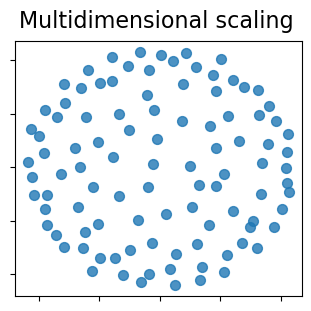

In [13]:
md_scaling = manifold.MDS(
    n_components=n_components,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
S_scaling = md_scaling.fit_transform(X_tfidf_test.toarray())
print(S_scaling.shape)

plot_2d(S_scaling, "Multidimensional scaling")

(100, 2)


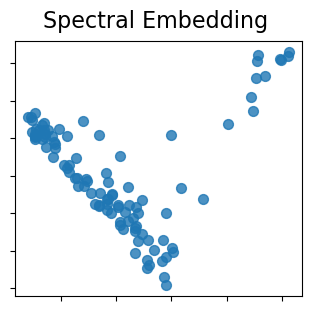

In [14]:
n_neighbors = 12
spectral = manifold.SpectralEmbedding(
    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)
S_spectral = spectral.fit_transform(X_tfidf_test.toarray())
print(S_spectral.shape)
plot_2d(S_spectral, "Spectral Embedding")

(100, 2)


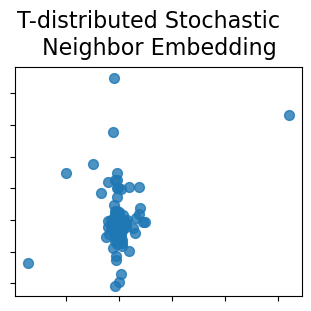

In [15]:
t_sne = manifold.TSNE(
    n_components=n_components,
    perplexity=30,
    init="random",
    n_iter=250,
    random_state=0
)
data_t_sne = t_sne.fit_transform(X_tfidf_test)
print(data_t_sne.shape)

plot_2d(data_t_sne, "T-distributed Stochastic  \n Neighbor Embedding")

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering
true_k = 11

In [32]:
kmeans = KMeans(                  # Can use MiniBatchKMeans if needed
    n_clusters=true_k,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\nwith tf-idf vectors")

clustering done in 7.28 ± 1.25 s 
V-measure: 0.282 ± 0.005
Adjusted Rand-Index: 0.008 ± 0.019
Silhouette Coefficient: 0.073 ± 0.009


In [14]:
from sklearn.neighbors import kneighbors_graph
knn_graph = kneighbors_graph(X_tfidf, 30, include_self=False, metric = 'cosine')

In [ ]:
agg = AgglomerativeClustering(linkage="complete", n_clusters=true_k, metric = "cosine", connectivity=knn_graph)
fit_and_evaluate(agg, X_tfidf.toarray(), name="Agglomerative clustering\nwith tf-idf vectors")

In [14]:
# Performing dimensionality reduction using LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print("Previous shape:", X_tfidf.shape)
print("New shape:", X_lsa.shape)
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 9.634 s
Previous shape: (2809, 244851)
New shape: (2809, 100)
Explained variance of the SVD step: 52.6%


In [15]:
kmeans = KMeans(                  # Can use MiniBatchKMeans if needed
    n_clusters=true_k,
    #max_iter=100,
    n_init=5,
)
fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.30 ± 0.12 s 
V-measure: 0.333 ± 0.023
Adjusted Rand-Index: 0.061 ± 0.027
Rand-Index: 0.747 ± 0.007
Silhouette Coefficient: 0.124 ± 0.016


In [16]:
from sklearn.neighbors import kneighbors_graph
knn_graph = kneighbors_graph(X_lsa, 30, include_self=False, metric = 'cosine')

In [17]:
agg = AgglomerativeClustering(linkage="complete", n_clusters=true_k, metric = "cosine", connectivity=knn_graph)
fit_and_evaluate(agg, X_lsa, name="Agglomerative clustering\nwith LSA on tf-idf vectors")

clustering done in 0.56 ± 0.44 s 
V-measure: 0.235 ± 0.000
Adjusted Rand-Index: 0.032 ± 0.000
Rand-Index: 0.701 ± 0.000
Silhouette Coefficient: -0.012 ± 0.000


In [24]:
# Top terms per cluster: 
# Since TfidfVectorizer can be inverted we can identify the cluster centers,
# which provide an intuition of the most influential words for each cluster.
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: agency plan name data fy mmr description goal open date 
Cluster 1: location report dbn category district administrative school 2018 name enrollment 
Cluster 2: year percent total of by rate count program month dfta 
Cluster 3: name city the borough geom id boro code new of 
Cluster 4: school discharge dbn students category code reporting 2015 name enrolled 
Cluster 5: size class of number level classes average students program grade 
Cluster 6: community board bin nta council tract latitude longitude census bbl 
Cluster 7: shape geom area the leng boro code name feat id 
Cluster 8: date id type number name status description permit street code 
Cluster 9: grade scale tested mean score results test 2006 number math 
Cluster 10: cohort pct regents graduation num grads advanced all outcomes demographic 


# Alternative vectorization using HashingVectorizer

In [28]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(n_features=50_000),      # stop_words="english", 
    TfidfTransformer(),                                        # For IDF weighting
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 27.932 s


In [29]:
kmeans = KMeans(                  # Can use MiniBatchKMeans if needed
    n_clusters=true_k,
    #max_iter=100,
    n_init=5,
)
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.23 ± 0.06 s 
V-measure: 0.286 ± 0.011
Adjusted Rand-Index: 0.030 ± 0.011
Silhouette Coefficient: 0.149 ± 0.009


In [30]:
knn_graph = kneighbors_graph(X_hashed_lsa, 30, include_self=False)
agg = AgglomerativeClustering(linkage="ward", n_clusters=true_k, metric = "euclidean", connectivity=knn_graph)
fit_and_evaluate(agg, X_hashed_lsa, name="Agglomerative clustering\nwith LSA on hashed vectors")

clustering done in 1.31 ± 2.01 s 
V-measure: 0.306 ± 0.000
Adjusted Rand-Index: 0.023 ± 0.000
Silhouette Coefficient: 0.123 ± 0.000


# Using word embedding vectors

In [28]:
! ls ../Module-2

sentence_transformer_embeddings.py
test_doc_vectors.npy
test_doc_vectors_glove_wiki_gigaword_100_bpemb_vs_200000.npy
test_doc_vectors_glove_wiki_gigaword_50_bpemb_vs_200000.npy
test_sentence_transformer_embeddings.npy
train_doc_vectors.npy
train_doc_vectors_glove_wiki_gigaword_100_bpemb_vs_200000.npy
train_doc_vectors_glove_wiki_gigaword_50_bpemb_vs_200000.npy
train_sentence_transformer_embeddings.npy
word_embeddings.py


In [18]:
path = os.path.join("../Module-2", "train_sentence_transformer_embeddings.npy")
dataset = np.load(path, allow_pickle=False)
print(type(dataset))
print(dataset.shape)
print(dataset[0])

<class 'numpy.ndarray'>
(2809, 384)
[ 2.69797188e-03 -5.19918539e-02 -3.21922861e-02 -3.66439559e-02
 -3.27955000e-02 -1.11898910e-02 -2.67021153e-02  3.17897499e-02
 -8.18883032e-02  8.21707398e-03  7.24862665e-02 -2.63631810e-02
 -5.17615527e-02 -2.10739039e-02  2.30604503e-02  6.59911260e-02
  6.09889627e-02  3.96482088e-02  3.15523073e-02 -5.27093336e-02
  5.65894395e-02  9.45328847e-02  5.31358123e-02  3.59515212e-02
 -6.24792203e-02  3.97300050e-02  7.20094144e-03 -2.55051348e-02
 -7.58659318e-02  3.00773904e-02  5.66068478e-02  6.74549639e-02
  1.28676683e-01  1.96742490e-02  1.35647714e-01  7.80227631e-02
  7.97612965e-03  8.34375843e-02 -7.32849771e-03 -1.61791667e-02
 -1.08737826e-01 -6.78261509e-03  2.09313482e-02  3.08867805e-02
 -5.73488846e-02 -2.72179078e-02 -9.71776918e-02 -2.20429264e-02
  4.64309454e-02  2.83704372e-03  7.70525113e-02 -3.21180634e-02
  4.92347032e-02  2.26366017e-02 -4.83488441e-02  3.24978530e-02
 -3.48599777e-02  5.32583222e-02  2.00906936e-02 -5.44

In [30]:
n_components = 2

In [19]:
from sklearn.cluster import KMeans
true_k = 11

In [20]:
kmeans = KMeans(                  # Can use MiniBatchKMeans if needed
    n_clusters=true_k,
    #max_iter=100,
    n_init=5,
)
fit_and_evaluate(kmeans, dataset, name="KMeans\nwith sentence embedding vectors")   #word

clustering done in 0.57 ± 0.07 s 
V-measure: 0.404 ± 0.027
Adjusted Rand-Index: 0.158 ± 0.035
Rand-Index: 0.778 ± 0.010
Silhouette Coefficient: 0.069 ± 0.008


In [21]:
dataset.shape

(2809, 384)

In [22]:
from sklearn.neighbors import kneighbors_graph
knn_graph = kneighbors_graph(dataset, 30, include_self=False)

In [23]:
from sklearn.cluster import AgglomerativeClustering

In [24]:
agg = AgglomerativeClustering(linkage="ward", n_clusters=true_k, metric = "euclidean", connectivity=knn_graph)
fit_and_evaluate(agg, dataset, name="Agglomerative clustering\nwith sentence embedding vectors") #word

clustering done in 0.57 ± 0.31 s 
V-measure: 0.412 ± 0.000
Adjusted Rand-Index: 0.229 ± 0.000
Rand-Index: 0.778 ± 0.000
Silhouette Coefficient: 0.052 ± 0.000


# Clustering evaluation

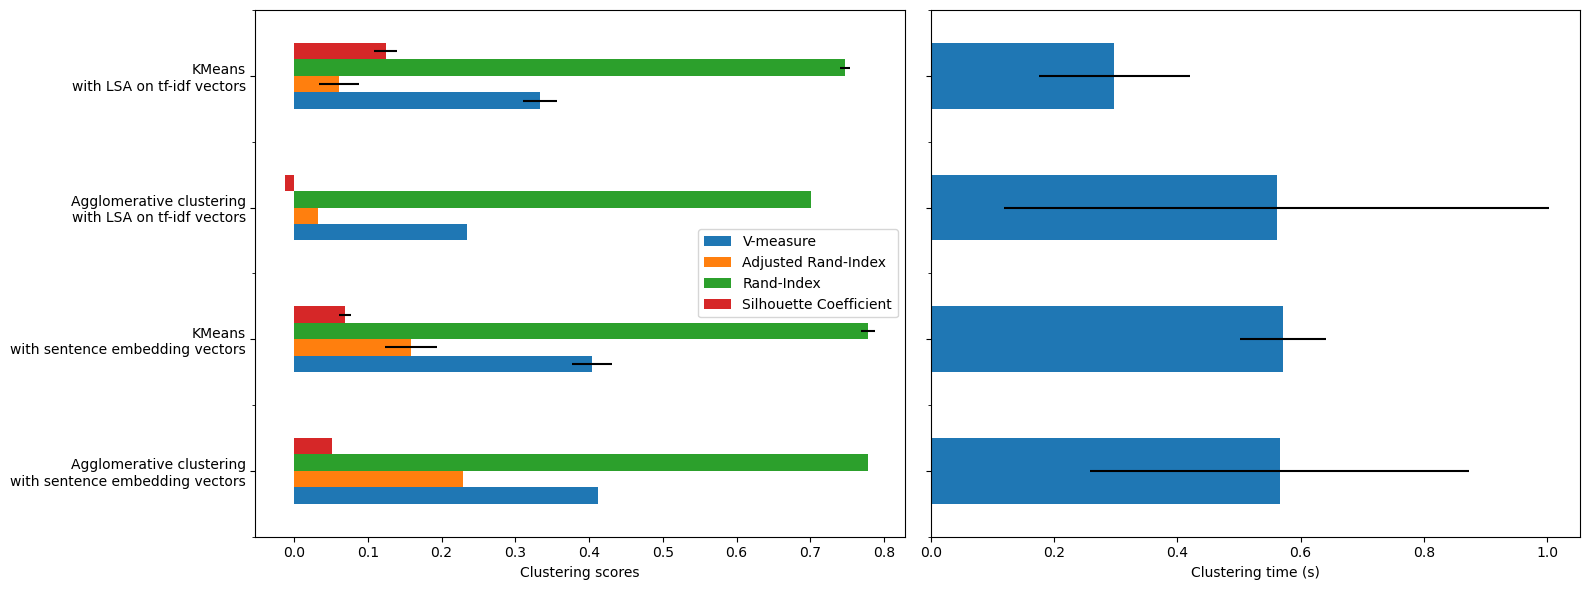

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()